Episode 1: Reward = 1.0
Episode 2: Reward = 1.0
Episode 3: Reward = -1.0
Episode 4: Reward = -1.0
Episode 5: Reward = -1.0
Episode 6: Reward = -1.0
Episode 7: Reward = 1.0
Episode 8: Reward = -1.0
Episode 9: Reward = 1.0
Episode 10: Reward = -1.0
Episode 11: Reward = -1.0
Episode 12: Reward = -1.0
Episode 13: Reward = -1.0
Episode 14: Reward = -1.0
Episode 15: Reward = -1.0
Episode 16: Reward = 1.0
Episode 17: Reward = 1.0
Episode 18: Reward = 0.0
Episode 19: Reward = -1.0
Episode 20: Reward = -1.0
Episode 21: Reward = -1.0
Episode 22: Reward = -1.0
Episode 23: Reward = -1.0
Episode 24: Reward = 1.0
Episode 25: Reward = 1.0
Episode 26: Reward = -1.0
Episode 27: Reward = -1.0
Episode 28: Reward = -1.0
Episode 29: Reward = -1.0
Episode 30: Reward = 1.0
Episode 31: Reward = -1.0
Episode 32: Reward = -1.0
Episode 33: Reward = 1.0
Episode 34: Reward = -1.0
Episode 35: Reward = 1.0
Episode 36: Reward = 1.0
Episode 37: Reward = -1.0
Episode 38: Reward = -1.0
Episode 39: Reward = -1.0
Episode 

ValueError: Input could not be cast to an at-least-1D NumPy array

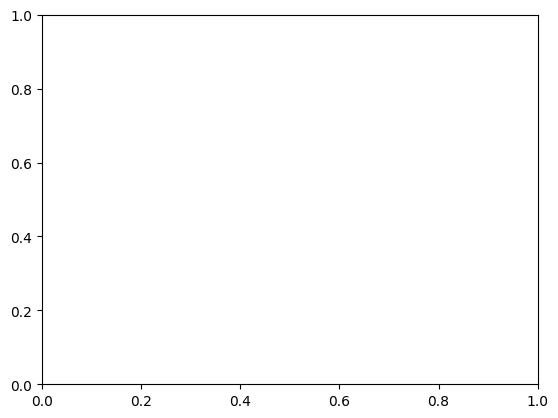

In [9]:
import gym
import torch
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# DDPG Agent Class (actor, critic, ve diğer bileşenler eklenmiştir)
class DDPGAgent:
    def __init__(self, state_size, action_size, learning_rate=1e-3, gamma=0.99, tau=0.001, buffer_size=100000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # Replay buffer
        self.replay_buffer = deque(maxlen=buffer_size)
        
        # Actor ve Critic modelleri burada tanımlanacak
        # DDPG için temel yapıyı oluşturmak amacıyla basit bir actor-critic modeli ekledik
        # Burada basit bir model kullanıyoruz, gerçek modelinizin detaylarını eklemeniz gerekebilir

    def select_action(self, state):
        # Aksiyon seçme fonksiyonu (örnek olarak rastgele seçim)
        return np.random.randint(self.action_size)

    def train(self):
        # Eğitme fonksiyonu, replay buffer'dan örnekler alır ve ağı eğitir
        if len(self.replay_buffer) < self.batch_size:
            return

        # Randomly sample from the replay buffer
        batch = random.sample(self.replay_buffer, self.batch_size)
        # Burada actor ve critic ağlarını eğitecek kodları eklemelisiniz

    def update_target_networks(self):
        # Target network'ü güncelleme (DDPG'de kullanılan teknik)
        pass


# Eğitim fonksiyonu
def train_ddpg(agent, env, num_episodes=1000):
    rewards_all_episodes = []  # Epizod başına ödülleri saklamak için bir liste

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action = agent.select_action(state)  # Aksiyon seçimi
            next_state, reward, done, truncated, info = env.step(action)  # Adım atma
            agent.replay_buffer.append((state, action, reward, next_state, done))  # Replay buffer'a ekle
            agent.train()  # Eğitme adımı

            state = next_state
            episode_reward += reward

        rewards_all_episodes.append(episode_reward)
        print(f"Episode {episode+1}: Reward = {episode_reward}")
    average_reward = np.mean(rewards_all_episodes)
    print(f"Total Average Reward over {num_episodes} episodes: {average_reward:.2f}")

    return rewards_all_episodes, average_reward


# Blackjack ortamını ve DDPG ajanını oluştur
env = gym.make("Blackjack-v1")  # Blackjack-v1 ortamını kullanıyoruz
state_size = 3  # Blackjack'de durum: [kart toplamı, açık kart, mevcut kart sayısı]
action_size = 2  # Blackjack'te aksiyonlar: 0 (HIT) ve 1 (STICK)
agent = DDPGAgent(state_size=state_size, action_size=action_size)  # State boyutu 3, action boyutu 2 (HIT, STICK)

# DDPG'yi eğit
rewards = train_ddpg(agent, env, num_episodes=1000)

# Sonuçları görselleştirme
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DDPG Agent Training Rewards for Blackjack')
plt.show()


Episode 1: Reward = 0.0
Episode 2: Reward = -1.0
Episode 3: Reward = 1.0
Episode 4: Reward = -1.0
Episode 5: Reward = -1.0
Episode 6: Reward = 1.0
Episode 7: Reward = 1.0
Episode 8: Reward = 1.0
Episode 9: Reward = 1.0
Episode 10: Reward = -1.0


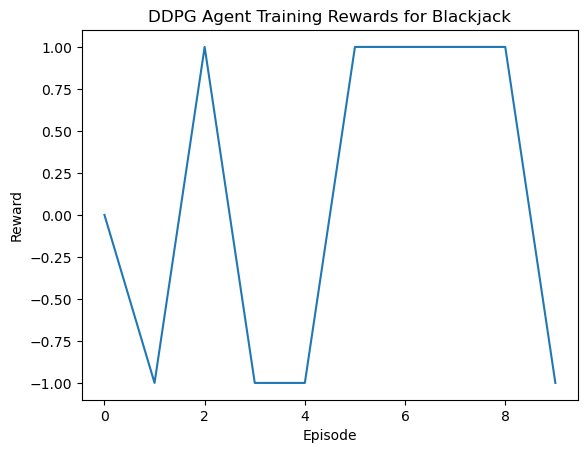

In [34]:
###yukarıdakinin kısa hali
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

class DDPGAgent:
    def __init__(self, state_size, action_size, learning_rate=1e-3, gamma=0.99, tau=0.001, buffer_size=100000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate, self.gamma, self.tau = learning_rate, gamma, tau
        self.batch_size = batch_size
        self.replay_buffer = deque(maxlen=buffer_size)

    def select_action(self, state):
        return np.random.randint(self.action_size)  # Basit rastgele seçim

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = random.sample(self.replay_buffer, self.batch_size)

        # Burada actor ve critic ağlarını eğitecek kod eklenmeli

    def update_target_networks(self):
        pass  # Bu fonksiyon henüz kullanılmıyor

def train_ddpg(agent, env, num_episodes=1000):
    rewards_all_episodes = []
    for episode in range(num_episodes):
        state, episode_reward, done = env.reset(), 0, False
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.replay_buffer.append((state, action, reward, next_state, done))
            agent.train()
            state, episode_reward = next_state, episode_reward + reward
        rewards_all_episodes.append(episode_reward)
        print(f"Episode {episode+1}: Reward = {episode_reward}")
    return rewards_all_episodes

# Blackjack ortamını oluştur ve ajanı başlat
env = gym.make("Blackjack-v1")
state_size, action_size = 3, 2  # Durum boyutu: [kart toplamı, açık kart, mevcut kart sayısı]
agent = DDPGAgent(state_size, action_size)

# DDPG'yi eğit
rewards = train_ddpg(agent, env, num_episodes=10)

# Sonuçları görselleştir
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DDPG Agent Training Rewards for Blackjack')
plt.show()
